# Model South Korea Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Mean Humidities
- Mean Wind speed
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Confirmed cases

**DATA sources:**

- Tested / Confirmed cases KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043376
- Confirmed cases by age KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043377
- Confirmed cases by area KR: https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043378
- Meteo South Korea (Seoul, Deagu, Busan): https://www.visualcrossing.com/weather-data


**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [46]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
import settings
from my_helpers.data_plots_kr import update_df_feat_kr
from my_helpers.data_plots_kr import load_df_feat_kr

from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

from my_helpers.dates import add_days
from my_helpers.dates import generate_list_dates

from my_helpers.model_kr import prepare_data_features_kr
from my_helpers.model_kr import prepare_dataset_kr

## Definitions

In [2]:
mode_train = False

In [3]:
#PATH_DF_FEAT_KR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_TO_SAVE_DATA = settings.PATH_TO_SAVE_DATA
from my_helpers.model_kr import PATH_MDL_MULTI_STEP_KR
#PATH_MDL_MULTI_STEP_KR = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_kr"

#PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
#    'serverless/tensorflow_lite_on_aws_lambda'
#PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
#    "converted_model.tflite"
#PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

#date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
#NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

#URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
from my_helpers.model_kr import PAST_HISTORY # days used to predict next values in future
from my_helpers.model_kr import FUTURE_TARGET  # predict 3 days later
from my_helpers.model_kr import STEP 


##  Helper functions

In [100]:
# FOR MODEL
# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()



def prepare_data_features_kr_old(df_feat_kr):
    df_out = df_feat_kr.copy().filter(items=["date", 'nb_cases', 
                                             'T_min', 'T_max', 'H_mean',
                                           'W_speed', 'pos', 'test', 'day_num',
                                           'age_pos'])
    df_out.fillna(method="pad", inplace=True)
    df_out.dropna(inplace=True)
    date_old = add_days(df_out.index[0].strftime("%Y-%m-%d"), -1)
    dates_index =  df_out.index.strftime("%Y-%m-%d")
    for date_curr in dates_index:
        if date_curr != add_days(date_old, 1):
            print("ERROR : ", date_curr)
            #break
        assert date_curr == add_days(date_old, 1)
        date_old = date_curr
    return df_out

## Retrieve data

In [8]:
df_feat_kr = update_df_feat_kr()
df_feat_kr

Updating Data KR...
update cases :  False
update age :  False
date_req_start:  None
date_req_start_age:  None
date_req_end:  None


nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-02-02       2.0        0.0        2.0  2020-02-02      0.0   NaN   
2020-02-03      15.0        0.0        0.0  2020-02-03      1.0   NaN   
2020-02-04       0.0        0.0        0.0  2020-02-04      2.0   NaN   
2020-02-05      19.0        0.0        0.0  2020-02-05      3.0   NaN   
2020-02-06      23.0        0.0        0.0  2020-02-06      4.0   NaN   
...              ...        ...        ...         ...      ...   ...   
2020-12-31   60739.0  4043541.0      900.0  2020-12-31      4.0   9.0   
2021-01-01   61767.0  4092389.0      917.0  2021-01-01      5.0   5.0   
2021-01-02   62587.0  4123406.0      942.0  2021-01-02      6.0  13.0   
2021-01-03   63244.0  4154366.0      962.0  2021-01-03      0.0   4.0   
2021-01-04   64264.0  4185876.0      981.0  2021-01-04      1.0  10.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  sum_Jeonbuk  \
date                                                ...                
2020-02-02        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-03        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-04        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-05        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-06        NaN        NaN      NaN      NaN  ...          NaN   
...               ...        ...      ...      ...  ...          ...   
2020-12-31       22.0       23.0      5.0     12.0  ...        222.0   
2021-01-01       35.0       24.0      6.0      8.0  ...        214.0   
2021-01-02       37.0       20.0     11.0     11.0  ...        210.0   
2021-01-03       12.0       14.0     12.0      5.0  ...        186.0   
2021-01-04       33.0       25.0      3.0     13.0  ...        186.0   

            Rt_Jeonbuk  sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                                           
2020-02-02         NaN          NaN         NaN            NaN           NaN   
2020-02-03         NaN          NaN         NaN            NaN           NaN   
2020-02-04         NaN          NaN         NaN            NaN           NaN   
2020-02-05         NaN          NaN         NaN            NaN           NaN   
2020-02-06         NaN          NaN         NaN            NaN           NaN   
...                ...          ...         ...            ...           ...   
2020-12-31    0.936709         75.0    1.339286          522.0      3.052632   
2021-01-01    0.895397         76.0    1.310345          515.0      2.668394   
2021-01-02    0.886076         82.0    1.389831          506.0      2.468293   
2021-01-03    0.732283         90.0    1.636364          495.0      2.260274   
2021-01-04    0.759184         84.0    1.377049          472.0      1.829457   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  
date                                                         
2020-02-02            NaN           NaN       NaN       NaN  
2020-02-03            NaN           NaN       NaN       NaN  
2020-02-04            NaN           NaN       NaN       NaN  
2020-02-05            NaN           NaN       NaN       NaN  
2020-02-06            NaN           NaN       NaN       NaN  
...                   ...           ...       ...       ...  
2020-12-31          390.0      1.387900     262.0  3.638889  
2021-01-01          381.0      1.233010     240.0  2.474227  
2021-01-02          386.0      1.229299     229.0  1.908333  
2021-01-03          347.0      0.994269     209.0  1.451389  
2021-01-04          365.0      1.048851     196.0  1.173653  

[338 rows x 87 columns]

## Reload data

In [105]:
df_feat_kr = load_df_feat_kr()
df_feat_kr

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-02-02       2.0        0.0        2.0  2020-02-02      0.0   NaN   
2020-02-03      15.0        0.0        0.0  2020-02-03      1.0   NaN   
2020-02-04       0.0        0.0        0.0  2020-02-04      2.0   NaN   
2020-02-05      19.0        0.0        0.0  2020-02-05      3.0   NaN   
2020-02-06      23.0        0.0        0.0  2020-02-06      4.0   NaN   
...              ...        ...        ...         ...      ...   ...   
2020-12-31   60739.0  4043541.0      900.0  2020-12-31      4.0   9.0   
2021-01-01   61767.0  4092389.0      917.0  2021-01-01      5.0   5.0   
2021-01-02   62587.0  4123406.0      942.0  2021-01-02      6.0  13.0   
2021-01-03   63244.0  4154366.0      962.0  2021-01-03      0.0   4.0   
2021-01-04   64264.0  4185876.0      981.0  2021-01-04      1.0  10.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  sum_Jeonbuk  \
date                                                ...                
2020-02-02        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-03        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-04        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-05        NaN        NaN      NaN      NaN  ...          NaN   
2020-02-06        NaN        NaN      NaN      NaN  ...          NaN   
...               ...        ...      ...      ...  ...          ...   
2020-12-31       22.0       23.0      5.0     12.0  ...        222.0   
2021-01-01       35.0       24.0      6.0      8.0  ...        214.0   
2021-01-02       37.0       20.0     11.0     11.0  ...        210.0   
2021-01-03       12.0       14.0     12.0      5.0  ...        186.0   
2021-01-04       33.0       25.0      3.0     13.0  ...        186.0   

            Rt_Jeonbuk  sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                                           
2020-02-02         NaN          NaN         NaN            NaN           NaN   
2020-02-03         NaN          NaN         NaN            NaN           NaN   
2020-02-04         NaN          NaN         NaN            NaN           NaN   
2020-02-05         NaN          NaN         NaN            NaN           NaN   
2020-02-06         NaN          NaN         NaN            NaN           NaN   
...                ...          ...         ...            ...           ...   
2020-12-31    0.936709         75.0    1.339286          522.0      3.052632   
2021-01-01    0.895397         76.0    1.310345          515.0      2.668394   
2021-01-02    0.886076         82.0    1.389831          506.0      2.468293   
2021-01-03    0.732283         90.0    1.636364          495.0      2.260274   
2021-01-04    0.759184         84.0    1.377049          472.0      1.829457   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  
date                                                         
2020-02-02            NaN           NaN       NaN       NaN  
2020-02-03            NaN           NaN       NaN       NaN  
2020-02-04            NaN           NaN       NaN       NaN  
2020-02-05            NaN           NaN       NaN       NaN  
2020-02-06            NaN           NaN       NaN       NaN  
...                   ...           ...       ...       ...  
2020-12-31          390.0      1.387900     262.0  3.638889  
2021-01-01          381.0      1.233010     240.0  2.474227  
2021-01-02          386.0      1.229299     229.0  1.908333  
2021-01-03          347.0      0.994269     209.0  1.451389  
2021-01-04          365.0      1.048851     196.0  1.173653  

[338 rows x 87 columns]

In [57]:
df_feat_kr.filter(items=["date", 'T_min', 'T_max', 'H_mean',
    'pos', 'test', 'day_num', 'age_pos', 
    'W_mean'])[df_feat_kr["date"] >= "2020-04-03"].head()

date     T_min      T_max     H_mean   pos     test  \
date                                                                    
2020-04-03  2020-04-03  5.233333  18.833333  46.640000  86.0  10507.0   
2020-04-04  2020-04-04  5.266667  18.000000  44.216667  94.0  10523.0   
2020-04-05  2020-04-05  2.633333  14.733333  36.973333  81.0   6774.0   
2020-04-06  2020-04-06  2.133333  16.633333  44.676667  47.0   5847.0   
2020-04-07  2020-04-07  6.900000  19.600000  47.673333  47.0   9145.0   

            day_num    age_pos  
date                            
2020-04-03      5.0  41.898165  
2020-04-04      6.0  41.898165  
2020-04-05      0.0  41.898165  
2020-04-06      1.0  41.898165  
2020-04-07      2.0  41.898165

In [58]:
df_feat_kr.filter(items=["date", 'T_min', 'T_max', 'H_mean',
    'pos', 'test', 'day_num', 'age_pos', 
    'W_speed'])[df_feat_kr["date"] >= "2020-06-10"].head()

date      T_min      T_max     H_mean   pos     test  \
date                                                                     
2020-06-10  2020-06-10  20.566667  32.766667  58.493333  50.0  17211.0   
2020-06-11  2020-06-11  21.633333  30.233333  75.713333  45.0  15645.0   
2020-06-12  2020-06-12  21.266667  29.033333  76.100000  56.0  15849.0   
2020-06-13  2020-06-13  20.733333  29.400000  73.890000  48.0  14109.0   
2020-06-14  2020-06-14  21.933333  28.733333  78.003333  34.0   7620.0   

            day_num    age_pos    W_speed  
date                                       
2020-06-10      3.0  51.110000  19.666667  
2020-06-11      4.0  45.177778  15.500000  
2020-06-12      5.0        NaN  16.566667  
2020-06-13      6.0  52.052885  16.900000  
2020-06-14      0.0  47.750000  23.400000

## Filter good data

In [106]:
df_feat_kr = prepare_data_features_kr(df_feat_kr)

df_feat_kr[df_feat_kr["date"] >= "2020-06-10"].head()

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-06-10   11902.0  1025748.0      276.0  2020-06-10      3.0   0.0   
2020-06-11   11947.0  1041393.0      276.0  2020-06-11      4.0   0.0   
2020-06-12   12003.0  1057242.0      277.0  2020-06-12      5.0   0.0   
2020-06-13   12051.0  1071351.0      277.0  2020-06-13      6.0   0.0   
2020-06-14   12085.0  1078971.0      277.0  2020-06-14      0.0   0.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  sum_Jeonbuk  \
date                                                ...                
2020-06-10        2.0        0.0      0.0      0.0  ...          0.0   
2020-06-11        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-12        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-13        0.0        0.0      0.0      0.0  ...          0.0   
2020-06-14        0.0        0.0      0.0      0.0  ...          0.0   

            Rt_Jeonbuk  sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                                           
2020-06-10         0.0          2.0         1.0            5.0      0.454545   
2020-06-11         0.0          2.0         2.0            4.0      0.363636   
2020-06-12         0.0          2.0         inf            4.0      0.363636   
2020-06-13         0.0          1.0         1.0            4.0      0.363636   
2020-06-14         0.0          1.0         1.0            4.0      0.363636   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju  Rt_Jeju  
date                                                        
2020-06-10            4.0           1.0       1.0      inf  
2020-06-11            4.0           1.0       1.0      inf  
2020-06-12            4.0           1.0       1.0      inf  
2020-06-13            4.0           1.0       1.0      inf  
2020-06-14            4.0           2.0       0.0      0.0  

[5 rows x 87 columns]

## Train/Test split

In [107]:
if mode_train:
    # keep 25 Validation samples:
    TRAIN_SPLIT = df_feat_kr.shape[0] - (2 * FUTURE_TARGET)
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model_kr import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 263


In [108]:
df_feat_kr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_kr.shape[0])]
df_feat_kr

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-04-03   10062.0   424365.0      174.0  2020-04-03      5.0   0.0   
2020-04-04   10156.0   434888.0      177.0  2020-04-04      6.0   0.0   
2020-04-05   10237.0   441662.0      183.0  2020-04-05      0.0   3.0   
2020-04-06   10284.0   447509.0      186.0  2020-04-06      1.0   0.0   
2020-04-07   10331.0   456654.0      192.0  2020-04-07      2.0   0.0   
...              ...        ...        ...         ...      ...   ...   
2020-12-31   60739.0  4043541.0      900.0  2020-12-31      4.0   9.0   
2021-01-01   61767.0  4092389.0      917.0  2021-01-01      5.0   5.0   
2021-01-02   62587.0  4123406.0      942.0  2021-01-02      6.0  13.0   
2021-01-03   63244.0  4154366.0      962.0  2021-01-03      0.0   4.0   
2021-01-04   64264.0  4185876.0      981.0  2021-01-04      1.0  10.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2020-04-03        1.0        5.0      1.0      1.0  ...    5.000000   
2020-04-04        1.0        1.0      0.0      0.0  ...    5.000000   
2020-04-05        1.0        4.0      0.0      1.0  ...    6.000000   
2020-04-06        2.0        2.0      0.0      0.0  ...    6.000000   
2020-04-07        1.0        1.0      0.0      0.0  ...    6.000000   
...               ...        ...      ...      ...  ...         ...   
2020-12-31       22.0       23.0      5.0     12.0  ...    0.936709   
2021-01-01       35.0       24.0      6.0      8.0  ...    0.895397   
2021-01-02       37.0       20.0     11.0     11.0  ...    0.886076   
2021-01-03       12.0       14.0     12.0      5.0  ...    0.732283   
2021-01-04       33.0       25.0      3.0     13.0  ...    0.759184   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2020-04-03         10.0         inf          106.0      4.240000   
2020-04-04         10.0         inf           67.0      1.030769   
2020-04-05          9.0    9.000000           60.0      0.789474   
2020-04-06          9.0    9.000000           60.0      0.769231   
2020-04-07          9.0    9.000000           60.0      0.759494   
...                 ...         ...            ...           ...   
2020-12-31         75.0    1.339286          522.0      3.052632   
2021-01-01         76.0    1.310345          515.0      2.668394   
2021-01-02         82.0    1.389831          506.0      2.468293   
2021-01-03         90.0    1.636364          495.0      2.260274   
2021-01-04         84.0    1.377049          472.0      1.829457   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2020-04-03           20.0     20.000000       5.0       inf   True  
2020-04-04           21.0     21.000000       5.0       inf   True  
2020-04-05           21.0     10.500000       8.0       inf   True  
2020-04-06           22.0      7.333333       8.0       inf   True  
2020-04-07           22.0      5.500000       8.0       inf   True  
...                   ...           ...       ...       ...    ...  
2020-12-31          390.0      1.387900     262.0  3.638889  False  
2021-01-01          381.0      1.233010     240.0  2.474227  False  
2021-01-02          386.0      1.229299     229.0  1.908333  False  
2021-01-03          347.0      0.994269     209.0  1.451389  False  
2021-01-04          365.0      1.048851     196.0  1.173653  False  

[277 rows x 88 columns]

In [62]:
df_feat_kr[df_feat_kr["train"] == False].head(5)

date     T_min      T_max     H_mean    W_speed     pos  \
date                                                                        
2020-12-23  2020-12-23 -4.333333   9.000000  70.356667  12.600000  1090.0   
2020-12-24  2020-12-24  0.333333  10.333333  65.170000  19.600000   983.0   
2020-12-25  2020-12-25 -3.733333   5.666667  46.320000  21.133333  1237.0   
2020-12-26  2020-12-26 -4.333333   9.000000  61.823333  11.333333  1132.0   
2020-12-27  2020-12-27 -0.666667   9.000000  66.676667   9.666667   970.0   

               test  day_num    age_pos  train  
date                                            
2020-12-23  52159.0      3.0  49.556422  False  
2020-12-24  58215.0      4.0  46.765514  False  
2020-12-25  50891.0      5.0  47.048100  False  
2020-12-26  29835.0      6.0  47.309629  False  
2020-12-27  27033.0      0.0  46.747938  False

### Exploration

Distribution of TRAIN / VALIDATION dataset :

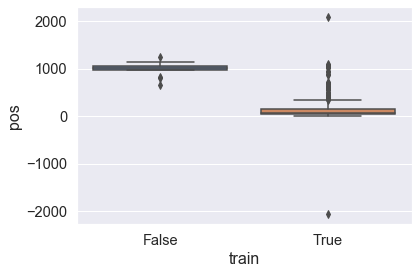

In [12]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_kr)

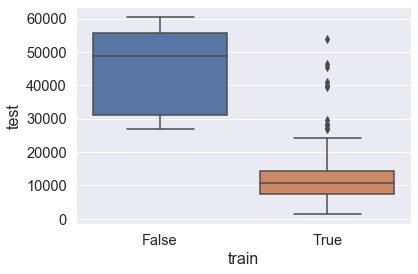

In [13]:
ax = sns.boxplot(x="train", y="test", data=df_feat_kr)

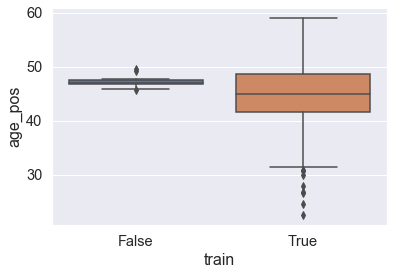

In [86]:
ax = sns.boxplot(x="train", y="age_pos", data=df_feat_kr)

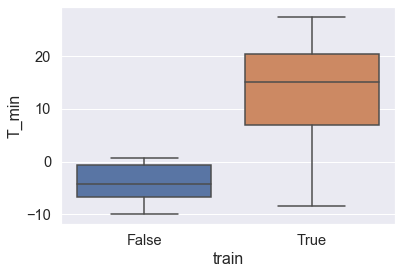

In [87]:
ax = sns.boxplot(x="train", y="T_min", data=df_feat_kr)

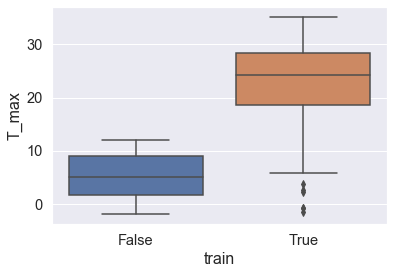

In [88]:
ax = sns.boxplot(x="train", y="T_max", data=df_feat_kr)

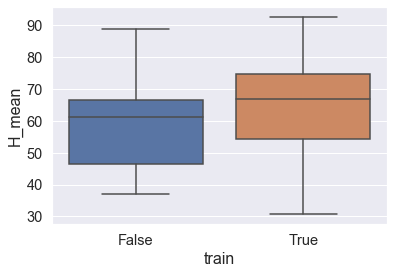

In [89]:
ax = sns.boxplot(x="train", y="H_mean", data=df_feat_kr)

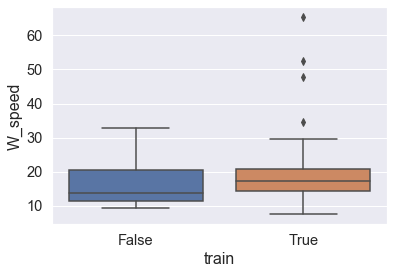

In [90]:
ax = sns.boxplot(x="train", y="W_speed", data=df_feat_kr)

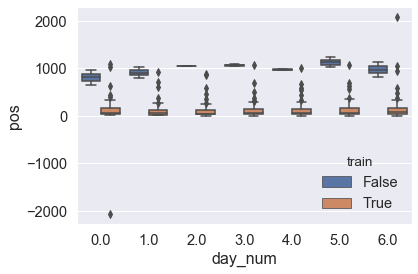

In [91]:
ax = sns.boxplot(x="day_num", y="pos", hue="train", data=df_feat_kr)

=> Hard to be confident for create a good model because train and test data are very different!

## Prepare features

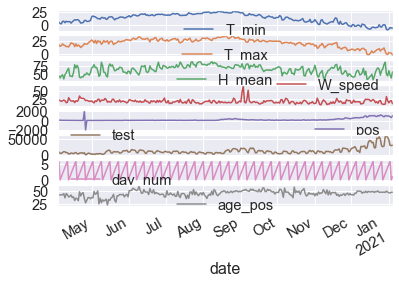

In [14]:
df_feat_kr.plot(subplots=True);

In [15]:
dataset, data_std, data_mean = prepare_dataset_kr(df_feat_kr)
print(dataset)
print("data_mean : ", data_mean)
print("data_std : ", data_std)

[[-0.97450826 -0.49350721 -1.2887581  ... -0.21416374  0.99528077
  -0.41215472]
 [-0.9705845  -0.60404409 -1.46231458 ... -0.2118543   1.49292115
  -0.41215472]
 [-1.28056105 -1.03734863 -1.98107417 ... -0.75298622 -1.49292115
  -0.41215472]
 ...
 [-2.22226195 -2.72635207 -1.29186159 ...  2.74625659  1.49292115
   0.22669013]
 [-2.30466078 -2.77498829 -1.97104752 ...  2.73802919 -1.49292115
   0.44381541]
 [-2.38705961 -3.25692906 -0.55060594 ...  2.81741637 -0.99528077
   0.44381541]]
data_mean :  [1.35120406e+01 2.25538657e+01 6.46346641e+01 1.82195184e+01
 1.54429658e+02 1.19907414e+04 3.00000000e+00 4.43632349e+01]
data_std :  [8.49526638e+00 7.53896237e+00 1.39627942e+01 6.06204431e+00
 2.85166288e+02 6.92807025e+03 2.00948322e+00 5.98093301e+00]


In [16]:
dataset.shape

(277, 8)

## Multi-step model

### Helper functions

In [17]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [105]:
TRAIN_SPLIT

263

In [106]:
dataset.shape

(277, 8)

In [107]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [108]:
y_train_multi.shape

(249, 7)

In [109]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

249 Single window of past history : (14, 8)

 249 Target temperature to predict : (7,)


In [110]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 249
BUFFER_SIZE : 263

For validation : 
BATCH_SIZE_VAL : 7


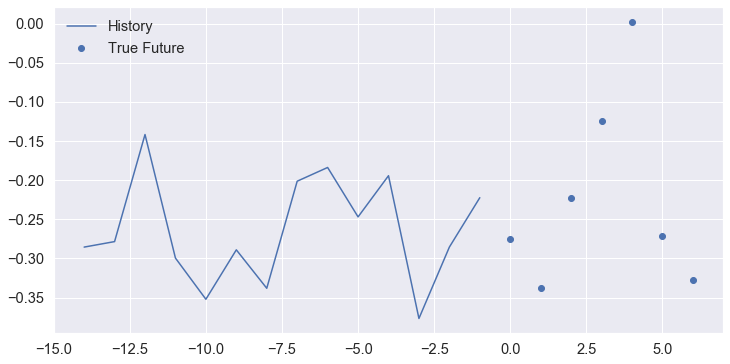

In [111]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [112]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 249
nb samples for validation : 7



 Run #0
Restoring model weights from the end of the best epoch.
Epoch 01578: early stopping
Run #0 : val_loss = 0.38150104880332947


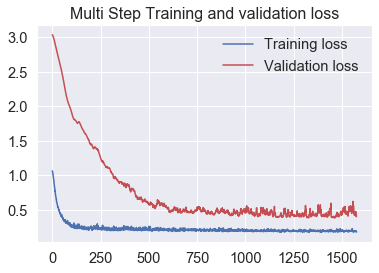

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #1
Restoring model weights from the end of the best epoch.
Epoch 01089: early stopping
Run #1 : val_loss = 0.3870071470737457

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 01552: early stopping
Run #2 : val_loss = 0.39556291699409485

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00926: early stopping
Run #3 : val_loss = 0.4412531852722168

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00961: early stopping
Run #4 : val_loss = 0.4052863121032715

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00861: early stopping
Run #5 : val_loss = 0.46489837765693665

 Run #6
Restoring model weights from the end of the best epoch.
Epoch 01031: early stopping
Run #6 : val_loss = 0.41508549451828003

 Run #7
Restoring model weights from the 

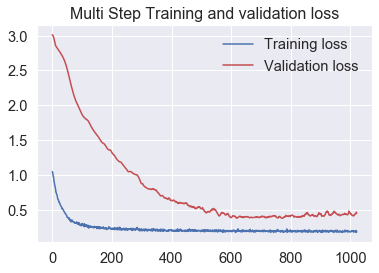

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 01138: early stopping
Run #9 : val_loss = 0.4474833607673645

 Run #10
Restoring model weights from the end of the best epoch.
Epoch 01159: early stopping
Run #10 : val_loss = 0.4134005606174469

 Run #11
Restoring model weights from the end of the best epoch.
Epoch 01254: early stopping
Run #11 : val_loss = 0.3856653571128845

 Run #12
Restoring model weights from the end of the best epoch.
Epoch 01224: early stopping
Run #12 : val_loss = 0.4189508855342865

 Run #13
Restoring model weights from the end of the best epoch.
Epoch 00880: early stopping
Run #13 : val_loss = 0.44774696230888367

 Run #14
Restoring model weights from the end of the best epoch.
Epoch 00976: early stopping
Run #14 : val_loss = 0.4049761891365051

 Run #15
Restoring model weights 

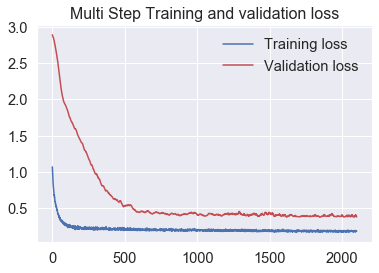

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #16
Restoring model weights from the end of the best epoch.
Epoch 01610: early stopping
Run #16 : val_loss = 0.37948599457740784

 Run #17
Restoring model weights from the end of the best epoch.
Epoch 01774: early stopping
Run #17 : val_loss = 0.4470241963863373

 Run #18
Restoring model weights from the end of the best epoch.
Epoch 00873: early stopping
Run #18 : val_loss = 0.6162856221199036

 Run #19
Restoring model weights from the end of the best epoch.
Epoch 01698: early stopping
Run #19 : val_loss = 0.37685051560401917

 Run #20
Restoring model weights from the end of the best epoch.
Epoch 01127: early stopping
Run #20 : val_loss = 0.3910200297832489

 Run #21
Restoring model weights from the end of the best epoch.
Epoch 01191: early stopping
Run #21 : val_loss = 0.4233672022819519

 Run #22
Restoring model weigh

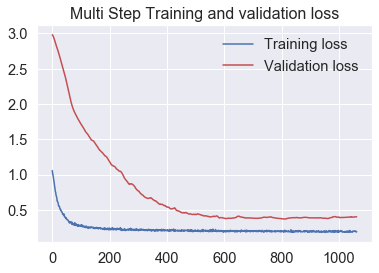

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #46
Restoring model weights from the end of the best epoch.
Epoch 00912: early stopping
Run #46 : val_loss = 0.43331173062324524

 Run #47
Restoring model weights from the end of the best epoch.
Epoch 01482: early stopping
Run #47 : val_loss = 0.36768731474876404


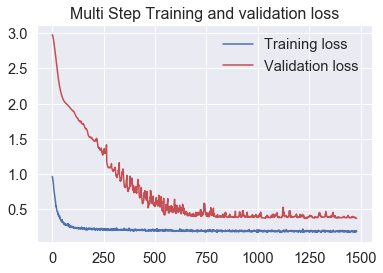

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #48
Restoring model weights from the end of the best epoch.
Epoch 00952: early stopping
Run #48 : val_loss = 0.4271104037761688

 Run #49
Restoring model weights from the end of the best epoch.
Epoch 01065: early stopping
Run #49 : val_loss = 0.3855920135974884

 Run #50
Restoring model weights from the end of the best epoch.
Epoch 01815: early stopping
Run #50 : val_loss = 0.36086440086364746


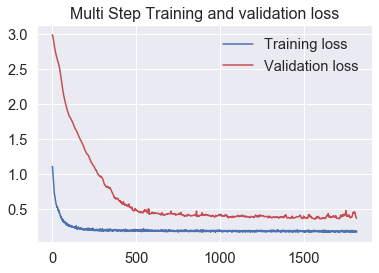

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #51
Restoring model weights from the end of the best epoch.
Epoch 00991: early stopping
Run #51 : val_loss = 0.41566941142082214

 Run #52
Restoring model weights from the end of the best epoch.
Epoch 01394: early stopping
Run #52 : val_loss = 0.4013592600822449

 Run #53
Restoring model weights from the end of the best epoch.
Epoch 01153: early stopping
Run #53 : val_loss = 0.40904930233955383

 Run #54
Restoring model weights from the end of the best epoch.
Epoch 01118: early stopping
Run #54 : val_loss = 0.49392589926719666

 Run #55
Restoring model weights from the end of the best epoch.
Epoch 01014: early stopping
Run #55 : val_loss = 0.39667871594429016

 Run #56
Restoring model weights from the end of the best epoch.
Epoch 01293: early stopping
Run #56 : val_loss = 0.40099555253982544

 Run #57
Restoring model we

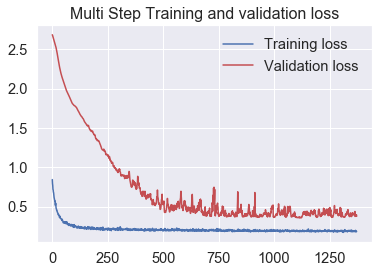

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #87
Restoring model weights from the end of the best epoch.
Epoch 02877: early stopping
Run #87 : val_loss = 0.35249289870262146


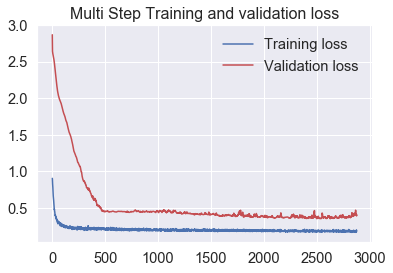

INFO:tensorflow:Assets written to: /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr/assets

 Run #88
Restoring model weights from the end of the best epoch.
Epoch 01294: early stopping
Run #88 : val_loss = 0.44253966212272644

 Run #89
Restoring model weights from the end of the best epoch.
Epoch 00873: early stopping
Run #89 : val_loss = 0.39662590622901917

 Run #90
Restoring model weights from the end of the best epoch.
Epoch 01344: early stopping
Run #90 : val_loss = 0.4991132915019989

 Run #91
Restoring model weights from the end of the best epoch.
Epoch 00957: early stopping
Run #91 : val_loss = 0.4033905863761902

 Run #92
Restoring model weights from the end of the best epoch.
Epoch 01040: early stopping
Run #92 : val_loss = 0.43516626954078674

 Run #93
Restoring model weights from the end of the best epoch.
Epoch 00745: early stopping
Run #93 : val_loss = 0.4514121413230896

 Run #94
Restoring model weig

Restoring model weights from the end of the best epoch.
Epoch 01166: early stopping
Run #147 : val_loss = 0.44028231501579285

 Run #148
Restoring model weights from the end of the best epoch.
Epoch 01205: early stopping
Run #148 : val_loss = 0.4726445972919464

 Run #149
Restoring model weights from the end of the best epoch.
Epoch 01360: early stopping
Run #149 : val_loss = 0.4219166338443756

 Run #150
Restoring model weights from the end of the best epoch.
Epoch 00949: early stopping
Run #150 : val_loss = 0.5253913402557373

 Run #151
Restoring model weights from the end of the best epoch.
Epoch 01419: early stopping
Run #151 : val_loss = 0.4084262549877167

 Run #152
Restoring model weights from the end of the best epoch.
Epoch 00931: early stopping
Run #152 : val_loss = 0.40701183676719666

 Run #153
Restoring model weights from the end of the best epoch.
Epoch 01552: early stopping
Run #153 : val_loss = 0.37905755639076233

 Run #154
Restoring model weights from the end of the b

Restoring model weights from the end of the best epoch.
Epoch 00919: early stopping
Run #208 : val_loss = 0.46072980761528015

 Run #209
Restoring model weights from the end of the best epoch.
Epoch 01222: early stopping
Run #209 : val_loss = 0.3845467269420624

 Run #210
Restoring model weights from the end of the best epoch.
Epoch 01339: early stopping
Run #210 : val_loss = 0.39466312527656555

 Run #211
Restoring model weights from the end of the best epoch.
Epoch 01076: early stopping
Run #211 : val_loss = 0.4086490571498871

 Run #212
Restoring model weights from the end of the best epoch.
Epoch 00914: early stopping
Run #212 : val_loss = 0.40417641401290894

 Run #213
Restoring model weights from the end of the best epoch.
Epoch 01201: early stopping
Run #213 : val_loss = 0.37446480989456177

 Run #214
Restoring model weights from the end of the best epoch.
Epoch 00985: early stopping
Run #214 : val_loss = 0.39238306879997253

 Run #215
Restoring model weights from the end of the

Restoring model weights from the end of the best epoch.
Epoch 01472: early stopping
Run #269 : val_loss = 0.41217657923698425

 Run #270
Restoring model weights from the end of the best epoch.
Epoch 01081: early stopping
Run #270 : val_loss = 0.5333852171897888

 Run #271
Restoring model weights from the end of the best epoch.
Epoch 01525: early stopping
Run #271 : val_loss = 0.38404974341392517

 Run #272
Restoring model weights from the end of the best epoch.
Epoch 01662: early stopping
Run #272 : val_loss = 0.3737019896507263

 Run #273
Restoring model weights from the end of the best epoch.
Epoch 00993: early stopping
Run #273 : val_loss = 0.3807564675807953

 Run #274
Restoring model weights from the end of the best epoch.
Epoch 01404: early stopping
Run #274 : val_loss = 0.39645668864250183

 Run #275
Restoring model weights from the end of the best epoch.
Epoch 01344: early stopping
Run #275 : val_loss = 0.37806329131126404

 Run #276
Restoring model weights from the end of the 

Restoring model weights from the end of the best epoch.
Epoch 01695: early stopping
Run #330 : val_loss = 0.40966448187828064

 Run #331
Restoring model weights from the end of the best epoch.
Epoch 01939: early stopping
Run #331 : val_loss = 0.3832445442676544

 Run #332
Restoring model weights from the end of the best epoch.
Epoch 01021: early stopping
Run #332 : val_loss = 0.5555102229118347

 Run #333
Restoring model weights from the end of the best epoch.
Epoch 01323: early stopping
Run #333 : val_loss = 0.4030473828315735

 Run #334
Restoring model weights from the end of the best epoch.
Epoch 00924: early stopping
Run #334 : val_loss = 0.4632135033607483

 Run #335
Restoring model weights from the end of the best epoch.
Epoch 01306: early stopping
Run #335 : val_loss = 0.3942317068576813

 Run #336
Restoring model weights from the end of the best epoch.
Epoch 01649: early stopping
Run #336 : val_loss = 0.36356431245803833

 Run #337
Restoring model weights from the end of the be

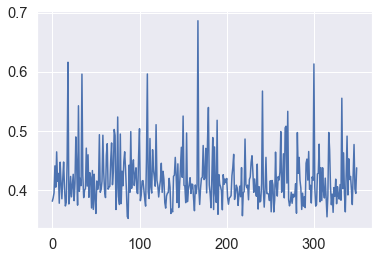

In [124]:
%%time
if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    NB_TRY = 350 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000 #5000

    # Hyper-parameters
    # lr=6e-2 : err=1.23 mais diverge
    # lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
    # lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
    # lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
    # lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
    # lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
    # lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
    # lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
    # lr=2e-2 : nb samples for training : 121 / nb samples for validation : 7
    # Final val_loss = 0.861526608467102 Mean asbolute Error in people : 3446.437551562592 Wall time: 2h 39min 39s
    # Final val_loss = 1.6073311567306519 Mean asbolute Error in people : 8765.89918940898 Wall time:3h28 patience=100
    # Final val_loss = 1.2980750799179077 Mean asbolute Error in people : 7079.309850490991 Wall time: 6h 31min 34s patience=250
    lr = 2e-2
    decay = 1e-6 #1e-6
    momentum = 0.9 # 0.9
    nesterov = True # True
    patience = 250 # 30

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=sgd_2, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP_KR)):
                os.mkdir(PATH_MDL_MULTI_STEP_KR)
            multi_step_model.save(PATH_MDL_MULTI_STEP_KR)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


### Eval

In [125]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

CPU times: user 2.99 s, sys: 349 ms, total: 3.34 s
Wall time: 4.04 s


In [126]:
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  100.51909796234426
Mean nb cases  [nb of cases]:  996.6530612244898
mean relative error [%]:  10.085665902520413


In [127]:
multi_step_model.predict(x_val_multi)

array([[2.6231558, 2.723976 , 2.8508108, 2.9361274, 3.0076785, 3.0312853,
        3.0534143],
       [2.925854 , 2.9952092, 3.056218 , 3.0666583, 3.0943027, 3.1219149,
        3.1555479],
       [2.9747145, 3.0280397, 3.071016 , 3.0648043, 3.0832493, 3.1145477,
        3.151385 ],
       [2.9345856, 2.9627464, 2.9653025, 2.922953 , 2.9198592, 2.9612794,
        3.0044632],
       [2.9081035, 2.938582 , 2.947573 , 2.9132526, 2.9175172, 2.9649045,
        3.0106108],
       [2.6834729, 2.7217722, 2.7764502, 2.802958 , 2.8434443, 2.8906236,
        2.9297836],
       [2.7005312, 2.7867916, 2.8550894, 2.8609207, 2.8826838, 2.8936443,
        2.9117124]], dtype=float32)

In [128]:
y_val_multi_pred.shape[0]

7

In [129]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 8), (None, 7)), types: (tf.float64, tf.float64)>

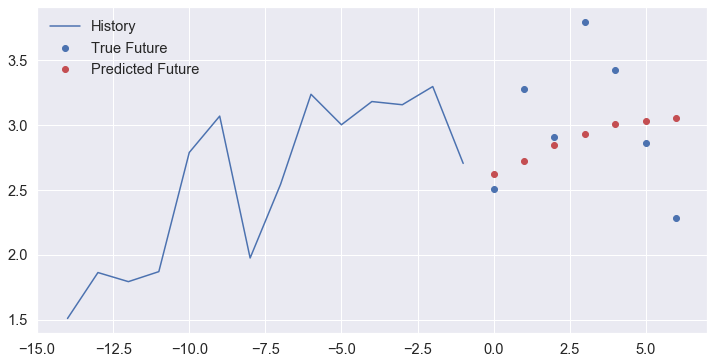

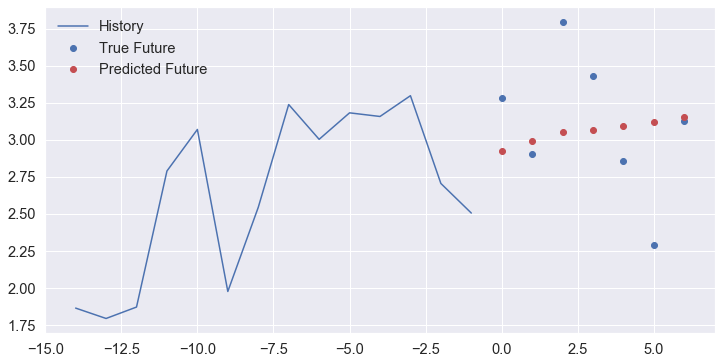

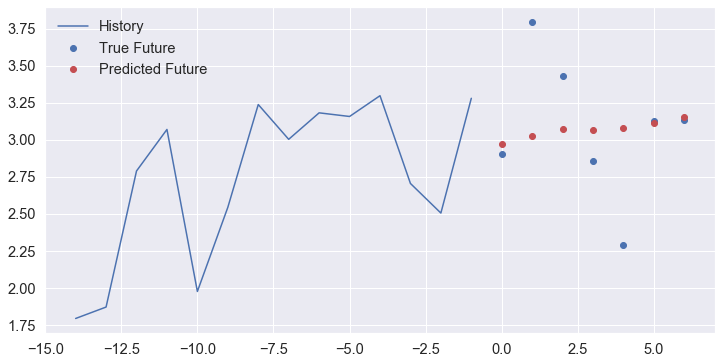

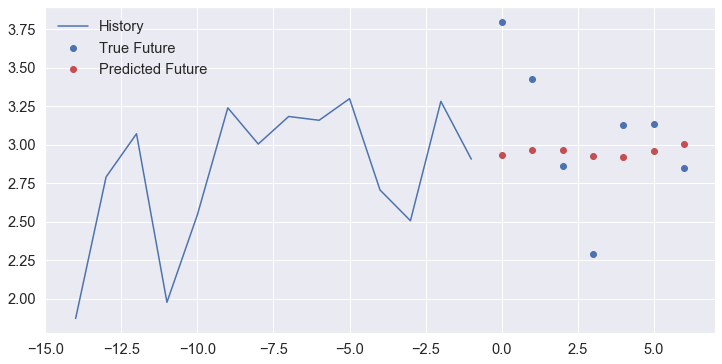

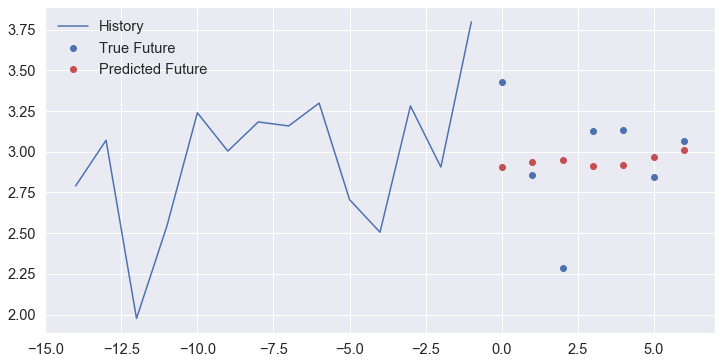

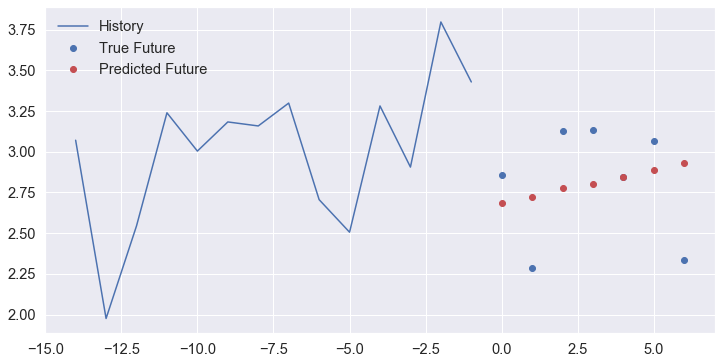

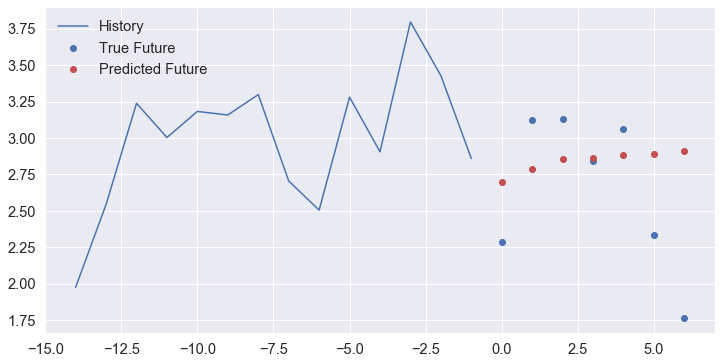

In [130]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [18]:
nb_period_plot = 9 #23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [19]:
PATH_MDL_MULTI_STEP_KR

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/mdl_multi_step_pos_kr'

In [20]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP_KR)

In [21]:
TRAIN_SPLIT

263

In [77]:
# reload data
df_feat_kr = load_df_feat_kr()
# clean data
df_feat_kr = prepare_data_features_kr(df_feat_kr)
# prepare features
dataset, data_std, data_mean = prepare_dataset_kr(features)

In [78]:
df_feat_kr.shape

(277, 9)

In [80]:
dataset.shape

(277, 8)

In [67]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 76 ms, sys: 234 ms, total: 310 ms
Wall time: 835 ms


In [81]:
df_feat_kr.date.min()

'2020-04-03'

In [82]:
df_feat_kr.date.max()

'2021-01-04'

In [83]:
df_feat_kr.pos.std()

333.29551203315503

In [84]:
data_std

array([8.49526638e+00, 7.53896237e+00, 1.39627942e+01, 6.06204431e+00,
       2.85166288e+02, 6.92807025e+03, 2.00948322e+00, 5.98093301e+00])

In [85]:
data_std[4]

285.16628761460936

In [86]:
str_date_0 = add_days(df_feat_kr.date.max(), -NB_DAY_PLOT)
str_date_0

'2020-11-02'

In [109]:
# last nth days
df_plot = df_feat_kr[df_feat_kr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_kr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date  pos  nb_cases
2021-01-05  2021-01-05  911   65175.0
2021-01-06  2021-01-06  931   66106.0
2021-01-07  2021-01-07  949   67055.0
2021-01-08  2021-01-08  952   68007.0
2021-01-09  2021-01-09  960   68967.0
2021-01-10  2021-01-10  966   69933.0
2021-01-11  2021-01-11  975   70908.0

In [110]:
df_feat_kr

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-04-03   10062.0   424365.0      174.0  2020-04-03      5.0   0.0   
2020-04-04   10156.0   434888.0      177.0  2020-04-04      6.0   0.0   
2020-04-05   10237.0   441662.0      183.0  2020-04-05      0.0   3.0   
2020-04-06   10284.0   447509.0      186.0  2020-04-06      1.0   0.0   
2020-04-07   10331.0   456654.0      192.0  2020-04-07      2.0   0.0   
...              ...        ...        ...         ...      ...   ...   
2020-12-31   60739.0  4043541.0      900.0  2020-12-31      4.0   9.0   
2021-01-01   61767.0  4092389.0      917.0  2021-01-01      5.0   5.0   
2021-01-02   62587.0  4123406.0      942.0  2021-01-02      6.0  13.0   
2021-01-03   63244.0  4154366.0      962.0  2021-01-03      0.0   4.0   
2021-01-04   64264.0  4185876.0      981.0  2021-01-04      1.0  10.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2020-04-03        1.0        5.0      1.0      1.0  ...    5.000000   
2020-04-04        1.0        1.0      0.0      0.0  ...    5.000000   
2020-04-05        1.0        4.0      0.0      1.0  ...    6.000000   
2020-04-06        2.0        2.0      0.0      0.0  ...    6.000000   
2020-04-07        1.0        1.0      0.0      0.0  ...    6.000000   
...               ...        ...      ...      ...  ...         ...   
2020-12-31       22.0       23.0      5.0     12.0  ...    0.936709   
2021-01-01       35.0       24.0      6.0      8.0  ...    0.895397   
2021-01-02       37.0       20.0     11.0     11.0  ...    0.886076   
2021-01-03       12.0       14.0     12.0      5.0  ...    0.732283   
2021-01-04       33.0       25.0      3.0     13.0  ...    0.759184   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2020-04-03         10.0         inf          106.0      4.240000   
2020-04-04         10.0         inf           67.0      1.030769   
2020-04-05          9.0    9.000000           60.0      0.789474   
2020-04-06          9.0    9.000000           60.0      0.769231   
2020-04-07          9.0    9.000000           60.0      0.759494   
...                 ...         ...            ...           ...   
2020-12-31         75.0    1.339286          522.0      3.052632   
2021-01-01         76.0    1.310345          515.0      2.668394   
2021-01-02         82.0    1.389831          506.0      2.468293   
2021-01-03         90.0    1.636364          495.0      2.260274   
2021-01-04         84.0    1.377049          472.0      1.829457   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2020-04-03           20.0     20.000000       5.0       inf   True  
2020-04-04           21.0     21.000000       5.0       inf   True  
2020-04-05           21.0     10.500000       8.0       inf   True  
2020-04-06           22.0      7.333333       8.0       inf   True  
2020-04-07           22.0      5.500000       8.0       inf   True  
...                   ...           ...       ...       ...    ...  
2020-12-31          390.0      1.387900     262.0  3.638889  False  
2021-01-01          381.0      1.233010     240.0  2.474227  False  
2021-01-02          386.0      1.229299     229.0  1.908333  False  
2021-01-03          347.0      0.994269     209.0  1.451389  False  
2021-01-04          365.0      1.048851     196.0  1.173653  False  

[277 rows x 88 columns]

In [111]:
df_feat_kr.iloc[TRAIN_SPLIT]["date"]

'2020-12-22'

In [112]:
df_plot

nb_cases   nb_tests  nb_deaths        date  day_num  Jeju  \
date                                                                    
2020-11-02   26732.0  2611126.0      468.0  2020-11-02      1.0   0.0   
2020-11-03   26807.0  2624044.0      472.0  2020-11-03      2.0   0.0   
2020-11-04   26925.0  2638005.0      474.0  2020-11-04      3.0   1.0   
2020-11-05   27050.0  2648644.0      475.0  2020-11-05      4.0   0.0   
2020-11-06   27195.0  2660685.0      476.0  2020-11-06      5.0   0.0   
...              ...        ...        ...         ...      ...   ...   
2020-12-31   60739.0  4043541.0      900.0  2020-12-31      4.0   9.0   
2021-01-01   61767.0  4092389.0      917.0  2021-01-01      5.0   5.0   
2021-01-02   62587.0  4123406.0      942.0  2021-01-02      6.0  13.0   
2021-01-03   63244.0  4154366.0      962.0  2021-01-03      0.0   4.0   
2021-01-04   64264.0  4185876.0      981.0  2021-01-04      1.0  10.0   

            Gyeongnam  Gyeongbuk  Jeonnam  Jeonbuk  ...  Rt_Jeonbuk  \
date                                                ...               
2020-11-02        1.0        1.0      2.0      0.0  ...    0.416667   
2020-11-03        1.0        0.0      0.0      0.0  ...    0.666667   
2020-11-04        0.0        2.0      0.0      0.0  ...    1.428571   
2020-11-05        5.0        0.0      0.0      0.0  ...    0.888889   
2020-11-06       13.0        1.0      0.0      1.0  ...    0.636364   
...               ...        ...      ...      ...  ...         ...   
2020-12-31       22.0       23.0      5.0     12.0  ...    0.936709   
2021-01-01       35.0       24.0      6.0      8.0  ...    0.895397   
2021-01-02       37.0       20.0     11.0     11.0  ...    0.886076   
2021-01-03       12.0       14.0     12.0      5.0  ...    0.732283   
2021-01-04       33.0       25.0      3.0     13.0  ...    0.759184   

            sum_Jeonnam  Rt_Jeonnam  sum_Gyeongbuk  Rt_Gyeongbuk  \
date                                                               
2020-11-02         13.0    3.250000           15.0      2.500000   
2020-11-03         13.0    3.250000           13.0      1.625000   
2020-11-04         12.0    2.400000           13.0      1.300000   
2020-11-05         12.0    2.400000           12.0      1.200000   
2020-11-06         11.0    2.200000           13.0      1.300000   
...                 ...         ...            ...           ...   
2020-12-31         75.0    1.339286          522.0      3.052632   
2021-01-01         76.0    1.310345          515.0      2.668394   
2021-01-02         82.0    1.389831          506.0      2.468293   
2021-01-03         90.0    1.636364          495.0      2.260274   
2021-01-04         84.0    1.377049          472.0      1.829457   

            sum_Gyeongnam  Rt_Gyeongnam  sum_Jeju   Rt_Jeju  train  
date                                                                
2020-11-02           19.0      2.375000       0.0       NaN   True  
2020-11-03           19.0      2.111111       0.0       NaN   True  
2020-11-04           19.0      2.111111       1.0       inf   True  
2020-11-05           24.0      4.000000       1.0       inf   True  
2020-11-06           37.0      7.400000       1.0       inf   True  
...                   ...           ...       ...       ...    ...  
2020-12-31          390.0      1.387900     262.0  3.638889  False  
2021-01-01          381.0      1.233010     240.0  2.474227  False  
2021-01-02          386.0      1.229299     229.0  1.908333  False  
2021-01-03          347.0      0.994269     209.0  1.451389  False  
2021-01-04          365.0      1.048851     196.0  1.173653  False  

[64 rows x 88 columns]

### Figure

In [114]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_kr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [225]:
nb_period_plot

9

In [226]:
19*7

133

In [227]:
179-4*7

151

In [228]:
dataset.shape

(179, 9)

In [115]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[200 - 214]
[207 - 221]
[214 - 228]
[221 - 235]
[228 - 242]
[235 - 249]
[242 - 256]
[249 - 263]
[256 - 270]
9
CPU times: user 540 ms, sys: 205 ms, total: 744 ms
Wall time: 1.15 s


array([[ 110.66412 ,  115.580246,  118.56093 ,  121.96298 ,  125.25475 ,
         129.04161 ,  134.54053 ,  138.33543 ,  147.86386 ,  160.91809 ,
         177.46422 ,  189.13292 ,  197.61052 ,  205.67947 ,  271.56055 ,
         287.04593 ,  307.41833 ,  331.30585 ,  347.75702 ,  357.24808 ,
         362.8896  ,  325.11945 ,  343.11267 ,  360.3051  ,  378.21387 ,
         393.37393 ,  404.34286 ,  412.6293  ,  462.99106 ,  487.78815 ,
         519.67834 ,  553.55164 ,  579.219   ,  593.2461  ,  602.64185 ,
         665.39575 ,  685.89087 ,  726.8445  ,  771.42554 ,  804.4784  ,
         821.0642  ,  831.3047  ,  820.62146 ,  869.8695  ,  914.1361  ,
         943.71936 ,  965.3086  ,  971.4104  ,  975.1708  ,  902.46533 ,
         931.2157  ,  967.3849  ,  991.71423 , 1012.1183  , 1018.8502  ,
        1025.1606  ,  900.1637  ,  928.31104 ,  944.3738  ,  939.9888  ,
         941.145   ,  941.0459  ,  944.9075  ]], dtype=float32)

In [116]:
y_pos_pred.shape

(1, 63)

In [117]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_kr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_kr[df_feat_kr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-11-02
2021-01-04


date  pos  nb_cases
2020-11-03  2020-11-03  110   26842.0
2020-11-04  2020-11-04  115   26957.0
2020-11-05  2020-11-05  118   27075.0
2020-11-06  2020-11-06  121   27196.0
2020-11-07  2020-11-07  125   27321.0
...                ...  ...       ...
2020-12-31  2020-12-31  944   60451.0
2021-01-01  2021-01-01  939   61390.0
2021-01-02  2021-01-02  941   62331.0
2021-01-03  2021-01-03  941   63272.0
2021-01-04  2021-01-04  944   64216.0

[63 rows x 3 columns]

### Figure all past 

In [118]:
str_date_mdl =  df_feat_kr.iloc[TRAIN_SPLIT]["date"]

In [119]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [120]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in South Korea</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()